
Обработка изображения класса: Гароу


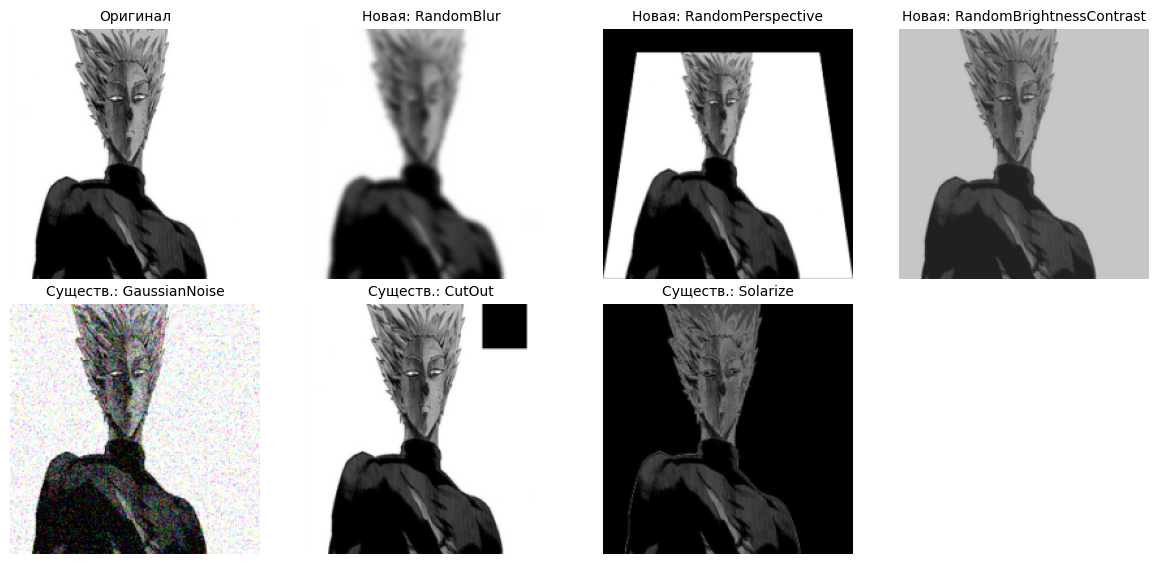


Обработка изображения класса: Генос


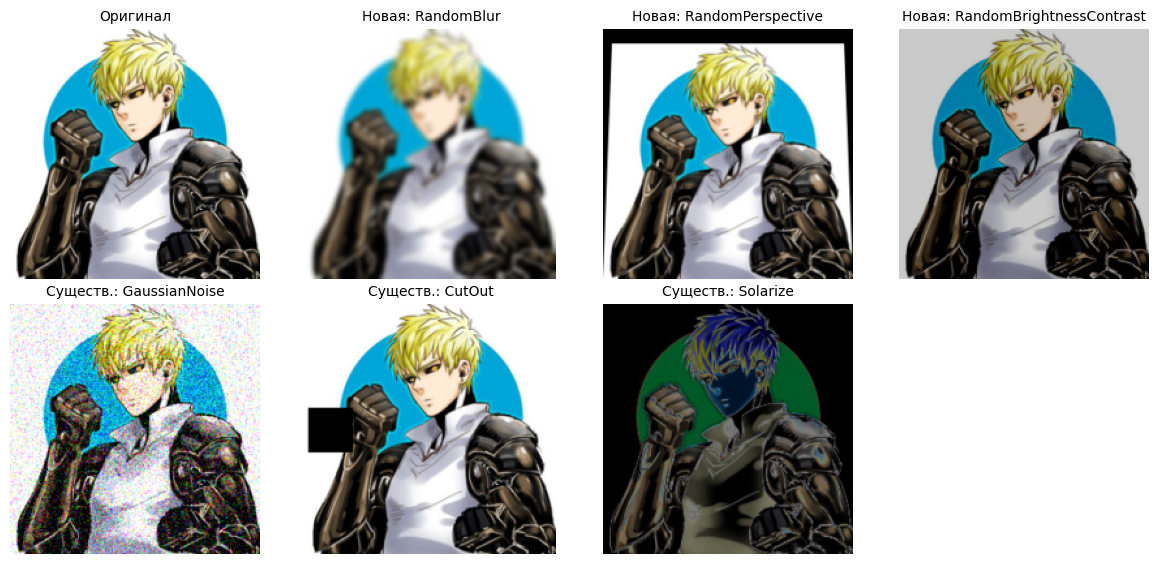


Обработка изображения класса: Сайтама


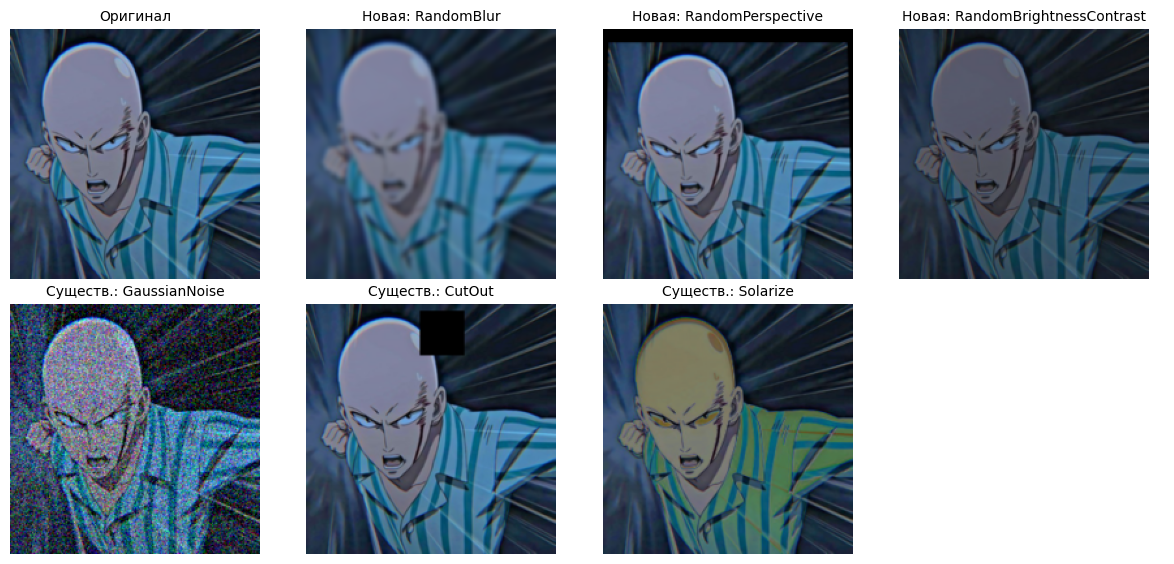


Обработка изображения класса: Соник


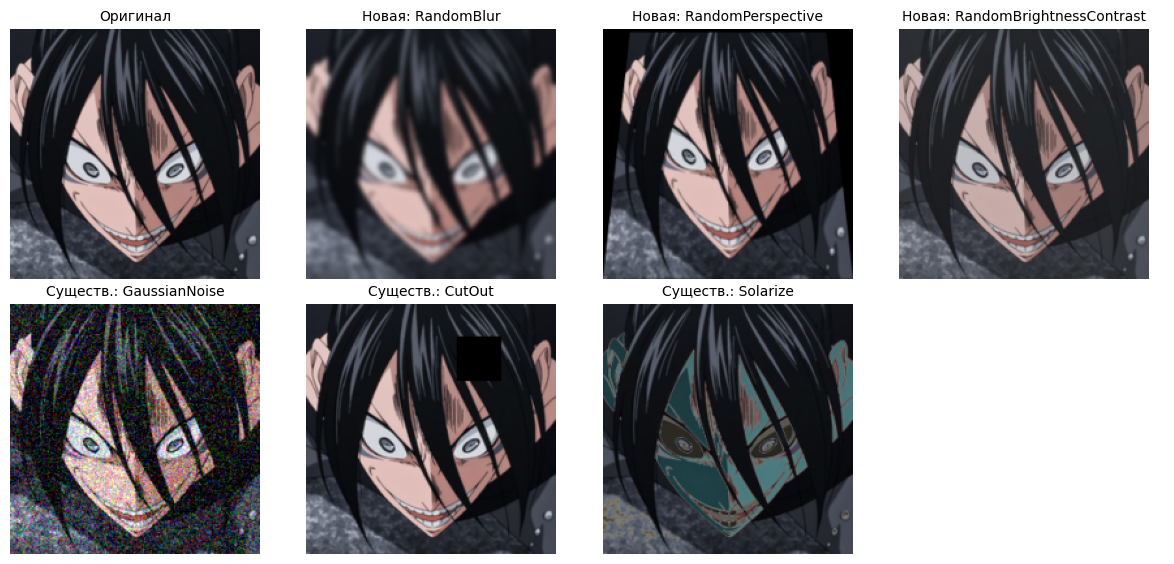


Обработка изображения класса: Татсумаки


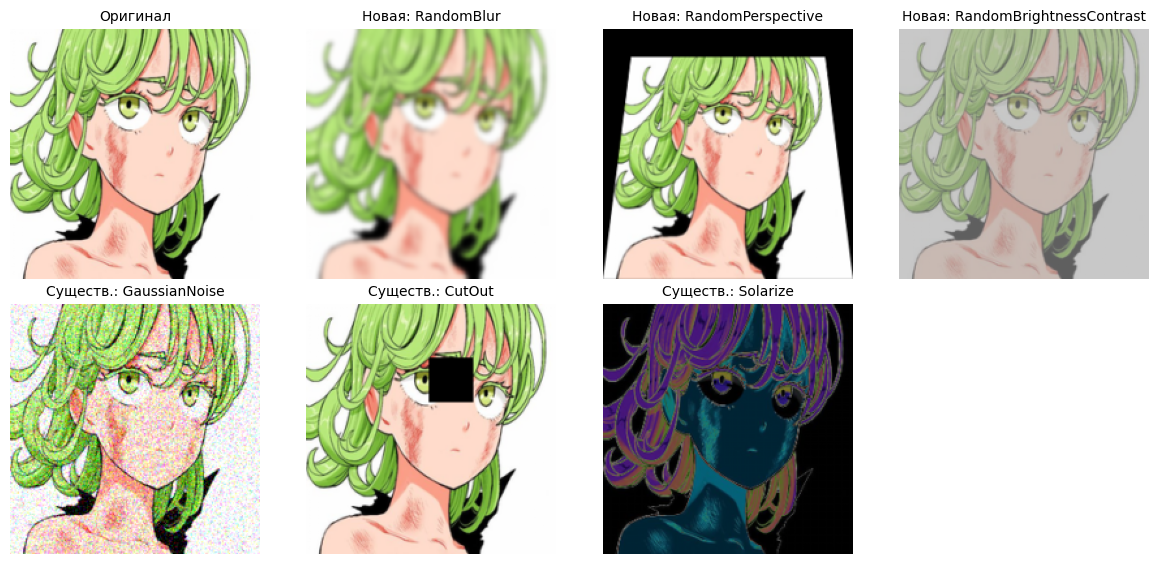


Обработка изображения класса: Фубуки


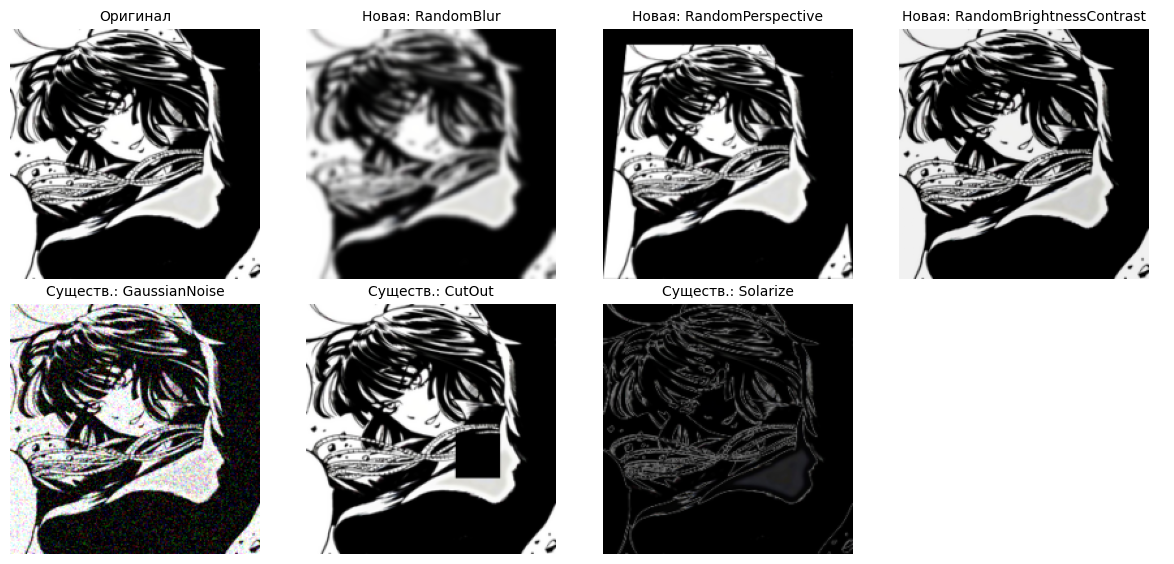

In [2]:
import random
from PIL import Image, ImageEnhance
import cv2
import numpy as np


class RandomBlur:
    """Случайное размытие изображения"""
    def __init__(self, p=0.5, kernel_size=5):
        self.p = p
        self.kernel_size = kernel_size
    
    def __call__(self, img):
        if random.random() < self.p:
            # Конвертируем тензор в numpy
            img_np = img.numpy().transpose(1, 2, 0)
            # Применяем размытие
            blurred = cv2.GaussianBlur(img_np, (self.kernel_size, self.kernel_size), 0)
            return torch.from_numpy(blurred.transpose(2, 0, 1))
        return img

class RandomPerspective:
    """Случайная перспективная трансформация"""
    def __init__(self, p=0.5, distortion_scale=0.5):
        self.p = p
        self.distortion_scale = distortion_scale
    
    def __call__(self, img):
        if random.random() < self.p:
            # Конвертируем тензор в PIL
            to_pil = transforms.ToPILImage()
            img_pil = to_pil(img)
            
            # Параметры перспективы
            w, h = img_pil.size
            half_w = w // 2
            half_h = h // 2
            
            # Генерируем случайные смещения
            dx = random.randint(0, int(self.distortion_scale * half_w))
            dy = random.randint(0, int(self.distortion_scale * half_h))
            
            # Точки для перспективной трансформации
            src_points = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
            dst_points = np.float32([
                [dx, dy], 
                [w - dx, dy], 
                [0, h], 
                [w, h]
            ])
            
            # Применяем перспективную трансформацию
            M = cv2.getPerspectiveTransform(src_points, dst_points)
            img_np = np.array(img_pil)
            transformed = cv2.warpPerspective(img_np, M, (w, h))
            
            return transforms.ToTensor()(transformed)
        return img

class RandomBrightnessContrast:
    """Случайное изменение яркости и контрастности"""
    def __init__(self, p=0.5, brightness_range=(0.7, 1.3), contrast_range=(0.7, 1.3)):
        self.p = p
        self.brightness_range = brightness_range
        self.contrast_range = contrast_range
    
    def __call__(self, img):
        if random.random() < self.p:
            # Конвертируем тензор в PIL
            to_pil = transforms.ToPILImage()
            img_pil = to_pil(img)
            
            # Изменяем яркость
            brightness_factor = random.uniform(*self.brightness_range)
            enhancer = ImageEnhance.Brightness(img_pil)
            img_pil = enhancer.enhance(brightness_factor)
            
            # Изменяем контраст
            contrast_factor = random.uniform(*self.contrast_range)
            enhancer = ImageEnhance.Contrast(img_pil)
            img_pil = enhancer.enhance(contrast_factor)
            
            return transforms.ToTensor()(img_pil)
        return img
    
    
import torchvision.transforms as transforms
from augmentations_basics.datasets import CustomImageDataset
from augmentations_basics.utils import show_multiple_augmentations
from augmentations_basics.extra_augs import *


# Путь к данным
data_path = "data/train"

# Создаем датасет без аугментаций
dataset = CustomImageDataset(
    root_dir=data_path,
    transform=None,
    target_size=(224, 224)
)

# Собираем по одному изображению из 3 разных классов
class_images = {}
for idx in range(len(dataset)):
    img, label = dataset[idx]
    if label not in class_images:
        class_name = dataset.classes[label]
        class_images[label] = (img, class_name)

# Создаем экземпляры новых кастомных аугментаций
new_augmentations = {
    "RandomBlur": RandomBlur(p=1.0, kernel_size=11),
    "RandomPerspective": RandomPerspective(p=1.0, distortion_scale=0.3),
    "RandomBrightnessContrast": RandomBrightnessContrast(
        p=1.0, 
        brightness_range=(0.4, 1.6),
        contrast_range=(0.4, 1.6)
    )
}

# Выбираем существующие аугментации для сравнения
existing_augmentations = {
    "GaussianNoise": AddGaussianNoise(mean=0., std=0.2),
    "CutOut": CutOut(p=1.0, size=(40, 40)),
    "Solarize": Solarize(threshold=128)
}

# Для каждого изображения применяем и сравниваем аугментации
for label, (img, class_name) in class_images.items():
    print(f"\nОбработка изображения класса: {class_name}")
    
    # Конвертируем в тензор
    to_tensor = transforms.ToTensor()
    img_tensor = to_tensor(img)
    
    # Применяем новые аугментации
    new_augmented_imgs = []
    new_titles = []
    for aug_name, augmentation in new_augmentations.items():
        augmented_img = augmentation(img_tensor.clone())
        new_augmented_imgs.append(augmented_img)
        new_titles.append(f"Новая: {aug_name}")
    
    # Применяем существующие аугментации
    existing_augmented_imgs = []
    existing_titles = []
    for aug_name, augmentation in existing_augmentations.items():
        augmented_img = augmentation(img_tensor.clone())
        existing_augmented_imgs.append(augmented_img)
        existing_titles.append(f"Существ.: {aug_name}")
    
    # Собираем все результаты для сравнения
    all_imgs = new_augmented_imgs + existing_augmented_imgs
    all_titles = new_titles + existing_titles
    
    # Визуализируем сравнение с ограничением 4 изображения в строке
    show_multiple_augmentations(
        img_tensor,
        all_imgs,
        all_titles,
        max_per_row=4
    )